In [25]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import itertools

from IPython.display import display, HTML

In [26]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_absolute_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_relative_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [27]:
index = target.Lake[target.Lake == 'Muskegon'].index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [28]:
hna_scores = pd.read_csv('Scores/hnascores_otus_5seq10_rel_Muskegon.csv', index_col=0)

#''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [29]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [30]:
kendall_rel = np.zeros(hna_scores.shape[0])
p_kendall_rel = np.zeros(hna_scores.shape[0])

i=0
for otu in hna_scores.index:
    kendall_rel[i], p_kendall_rel[i] = kendalltau(data_rel.loc[index_prod,otu],prod)
    i+=1

hna_scores['kendall_prod_rel'] = kendall_rel
hna_scores['p_kendall_prod_rel'] = p_kendall_rel

In [31]:
display(hna_scores.head(5))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall,kendall_prod_rel,p_kendall_prod_rel
Otu000173,0.662,19183.863568,1.389539,0.002640,1.213961,0.518860,5.505006e-09,0.273507,0.096638
Otu000905,0.584,1722.747677,1.597538,0.000223,1.367060,0.298122,2.275539e-03,0.432294,0.014044
Otu000242,0.548,4279.004838,1.331277,0.000632,1.054300,0.210994,2.225148e-02,0.099062,0.569147
Otu000060,0.528,45526.565552,1.078545,0.006393,0.679089,0.391586,8.120894e-06,0.279684,0.085350
Otu000059,0.502,29773.174200,0.587921,0.005351,0.567443,-0.209356,1.716857e-02,0.085573,0.602409


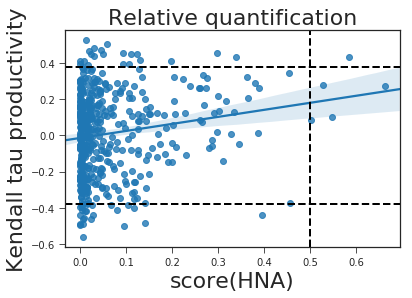

In [32]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_rel'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()

In [ ]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_rel'] > 0.377)].index
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    plt.axis([-0.0001,0.001,0,100])
    sns.regplot(x=data_rel.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Relative abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

In [34]:
kendall_sum_rel = np.zeros(hna_scores.shape[0])
p_kendall_sum_rel = np.zeros(hna_scores.shape[0])
kendall_sum_rel_thr = np.zeros(hna_scores.shape[0])
p_kendall_sum_rel_thr = np.zeros(hna_scores.shape[0])

sum_rel = np.zeros(len(index_prod))
sum_rel_thr = np.zeros(len(index_prod))

i=0
thr = 0
for otu in hna_scores.index:
    sum_rel += data_rel.loc[index_prod,otu]
    sum_rel_thr += data_rel.loc[index_prod,otu]
    kendall_sum_rel[i], p_kendall_sum_rel[i] = kendalltau(sum_rel,prod)
    kendall_sum_rel_thr[i], p_kendall_sum_rel_thr[i] = kendalltau(sum_rel_thr,prod)
    if kendall_sum_rel_thr[i] > thr: 
        thr = kendall_sum_rel_thr[i]
    else: 
        sum_rel_thr -= data_rel.loc[index_prod,otu]
        kendall_sum_rel_thr[i] = 0
    i+=1

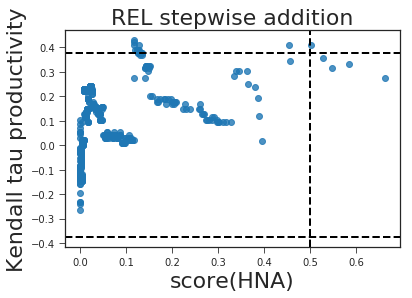

In [35]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_rel, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('REL stepwise addition', size=22)
plt.show()

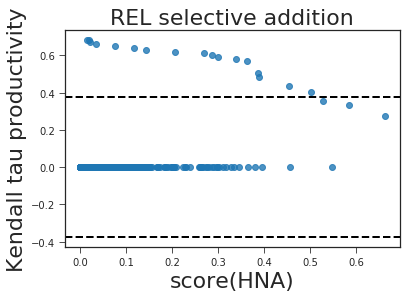

In [36]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_rel_thr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('REL selective addition', size=22)
plt.show()

In [37]:
otus_prod = hna_scores.loc[kendall_sum_rel_thr > 0,:].index
print('OTUs part of productivity correlation pool:' + str(otus_prod))

OTUs part of productivity correlation pool:Index(['Otu000173', 'Otu000905', 'Otu000060', 'Otu000059', 'Otu000067',
       'Otu000682', 'Otu000030', 'Otu000359', 'Otu000614', 'Otu000409',
       'Otu000390', 'Otu000255', 'Otu000655', 'Otu000063', 'Otu001100',
       'Otu001520', 'Otu000578', 'Otu000230', 'Otu000162', 'Otu000833'],
      dtype='object')


In [38]:
lna_scores = pd.read_csv('Scores/lnascores_otus_5seq10_rel_Muskegon.csv', index_col=0)

kendall_sum_rel = np.zeros(lna_scores.shape[0])
p_kendall_sum_rel = np.zeros(lna_scores.shape[0])
kendall_sum_rel_thr = np.zeros(lna_scores.shape[0])
p_kendall_sum_rel_thr = np.zeros(lna_scores.shape[0])

sum_rel = np.zeros(len(index_prod))
sum_rel_thr = np.zeros(len(index_prod))

i=0
thr = 0
for otu in lna_scores.index:
    sum_rel += data_rel.loc[index_prod,otu]
    sum_rel_thr += data_rel_clr.loc[index_prod,otu]
    kendall_sum_rel[i], p_kendall_sum_rel[i] = kendalltau(sum_rel,prod)
    kendall_sum_rel_thr[i], p_kendall_sum_rel_thr[i] = kendalltau(sum_rel_thr,prod)
    if kendall_sum_rel_thr[i] > thr: 
        thr = kendall_sum_rel_thr[i]
    else: 
        sum_rel_thr -= data_rel_clr.loc[index_prod,otu]
        kendall_sum_rel_thr[i] = 0
    i+=1

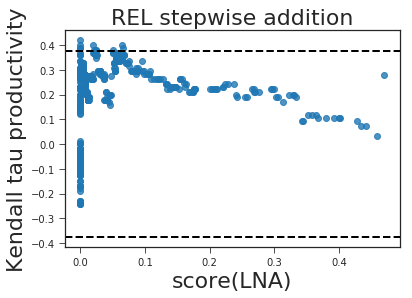

In [39]:
plt.figure()
sns.regplot(x=lna_scores.loc[:,'score'],y=kendall_sum_rel, fit_reg=False)
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('REL stepwise addition', size=22)
plt.show()

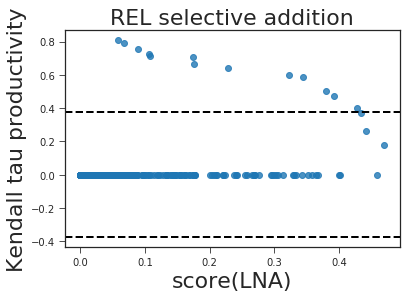

In [40]:
plt.figure()
sns.regplot(x=lna_scores.loc[:,'score'],y=kendall_sum_rel_thr, fit_reg=False)
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('REL selective addition', size=22)
plt.show()